### GAN 훈련 성능 향상하기 

* 모드 붕괴를 고치고 이미지 선명도를 높이기 위한 방법
* 훈련 품질을 높이자 

* BCELoss를 이용해 MSELoss를 대체
    * 분류 문제에서 이손실 함수가 더 잘 작동함 : 보상과 벌이 강하기 때문
* 활성화 함수를 LeakyReLU()로 적용.
    * sigmoid는 가장 마지막 layer에만 적용 
* LayerNormalization 적용 
* optimizer Adam 사용 
* input node의 개수를 늘리기 


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## MNIST Dataset 

In [4]:
# dataset class
# data를 tensor로 묶고, 각 레코드마다 정답 레이블, 0부터 1사이의 값으로 재조정된 이미지 픽셀값, 원핫 인코딩이 된 텐서를 반환

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='gray')
        pass
    
    pass

In [6]:
# load data

mnist_dataset = MnistDataset('mnist_train.csv')

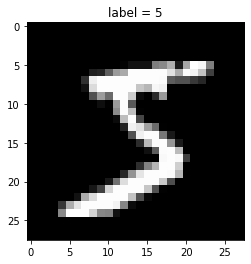

In [7]:
# check data contains images

mnist_dataset.plot_image(0)

## Noise function

In [8]:
# function to generate uniform random data
# 원하는 size의 ramdom data를 생성 

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [2]:
torch.rand(784)

tensor([0.5415, 0.2889, 0.6808, 0.6766, 0.2544, 0.9644, 0.0871, 0.6615, 0.5157,
        0.5324, 0.9865, 0.2967, 0.0283, 0.3548, 0.0786, 0.2279, 0.7953, 0.8420,
        0.6596, 0.7612, 0.6101, 0.5476, 0.8821, 0.0047, 0.2730, 0.7048, 0.1218,
        0.1529, 0.3324, 0.4762, 0.5434, 0.8688, 0.4195, 0.6763, 0.0031, 0.4555,
        0.0415, 0.5794, 0.8910, 0.3757, 0.6660, 0.0183, 0.9073, 0.2001, 0.9154,
        0.7779, 0.2657, 0.8913, 0.4699, 0.4457, 0.7437, 0.7311, 0.4904, 0.2284,
        0.5115, 0.4287, 0.9152, 0.5520, 0.2017, 0.1032, 0.8664, 0.1330, 0.7425,
        0.1337, 0.8911, 0.2155, 0.7939, 0.1218, 0.2781, 0.2116, 0.9258, 0.6233,
        0.0040, 0.0632, 0.1458, 0.6075, 0.6181, 0.1915, 0.9254, 0.5697, 0.4023,
        0.5852, 0.5805, 0.3854, 0.2935, 0.1228, 0.6362, 0.6264, 0.0822, 0.1379,
        0.6770, 0.6638, 0.3304, 0.6523, 0.8739, 0.3861, 0.4986, 0.7313, 0.4995,
        0.3281, 0.1464, 0.7238, 0.9764, 0.6613, 0.8934, 0.0714, 0.2485, 0.7984,
        0.7370, 0.2006, 0.7953, 0.7586, 

## Discriminator

In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [10]:
%%time 

# 작업시간 측정
# test discriminator can separate real data from random noise
# 진짜 숫자라고 판단하면 결과를 1.0으로 출력

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 15s, sys: 55.1 s, total: 4min 10s
Wall time: 2min 46s


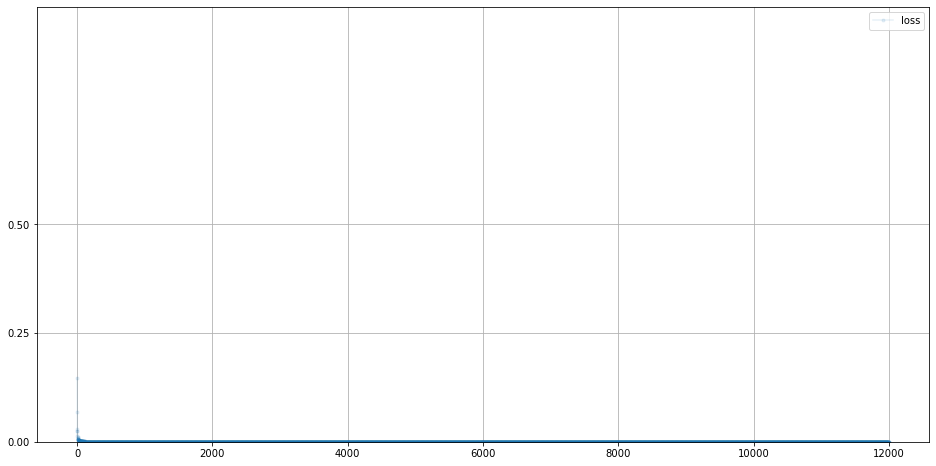

In [11]:
# plot discriminator loss
# loss가 0근처에서 유지됨 : 판별기의 성능이 계속해서 생성기에 비해 우세. 판별기의 성능이 안나옴 

D.plot_progress()

In [12]:
# manually run discriminator to check it can tell real data from fake
# 실제 데이터를 수동으로 넣어서 결과 확인 

# 실제데이터의 확률
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print( D.forward( image_data_tensor ).item() )
    pass

# 가짜데이터의 확률
for i in range(4):
    print( D.forward( generate_random(784) ).item() )
    pass

1.0
1.0
1.0
1.0
9.250570795482638e-12
8.32761463953613e-12
9.027754238610797e-12
9.399401396104068e-12


## Generator

In [18]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers 28x28=784
        self.model = nn.Sequential(
#            nn.Linear(1, 200),
            nn.Linear(100, 200), # 더 많은 입력노드를 넣게 모델 수정 
            
            nn.LeakyReLU(0.02),
            
            nn.LayerNorm(200),
            
            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

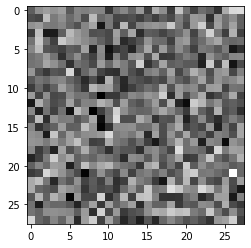

In [14]:
# 훈련하기 전 생성기의 output이 잘 생성 되는지 확인

G = Generator()

output = G.forward(generate_random(1))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='gray')

## train

In [15]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true : 실제 데이터 - 1.0
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false : 가짜 데이터 - 0.0
    # use detach() so gradients in G are not calculated : G의 기울기가 계산되지 않게 detach 사용
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # train generator 
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 5min 35s, sys: 1min 28s, total: 7min 4s
Wall time: 4min 44s


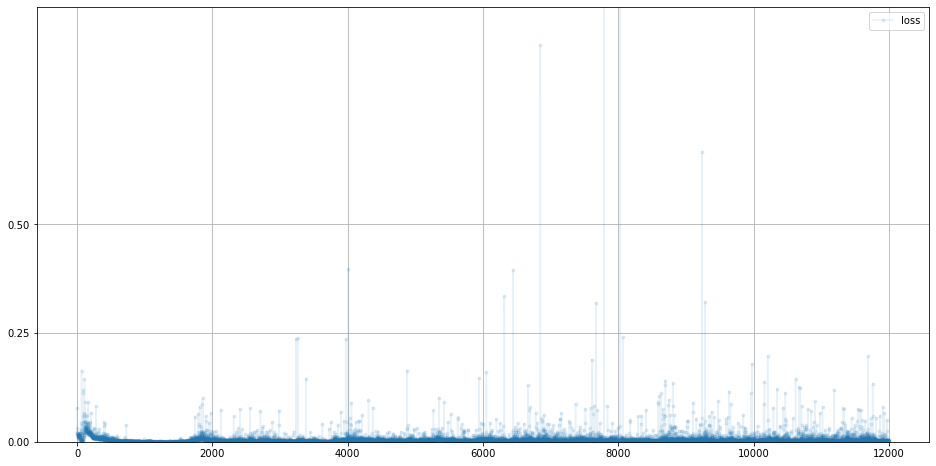

In [16]:
# plot discriminator error
# loss가 0에 가까운 경우 : 판별기가 생성기를 앞섬, 생성기의 성능이 떨어져서 속일수 없는 상태
# loss가 0.25일때 판별기와 생성기의 균형이 맞음

D.plot_progress()

## mode collapse(Helvetica scenario)

* generator가 서로 다른 z들을 하나의 결과물로 생성.  

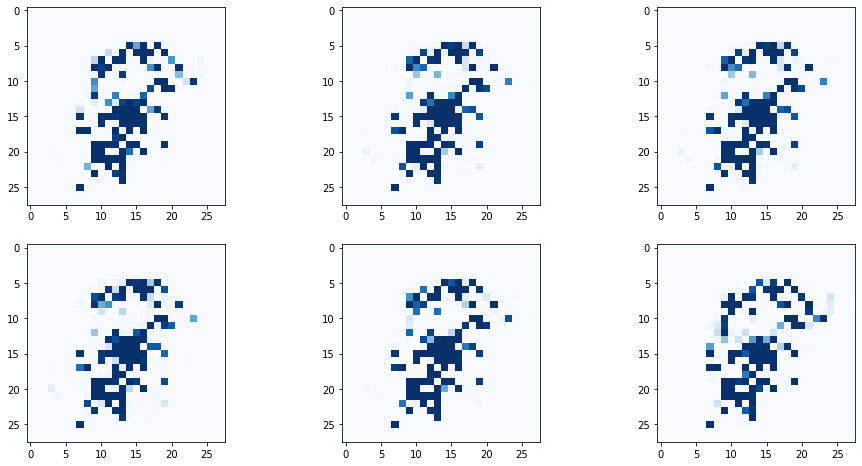

In [18]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

### 판별기와 생성기에 주는 random값이 달라져야함
* 판별기 입력 random값 :  0~1사이의 이미지 픽셀값, 경향이 없는 데이터 
* 생성기 입력 random값 : 0~1사이가 아니어도 상관 없는 값, 표준 정규분포를 따르는 값이 더 유리

## Noise Function 

In [19]:
# 판별기 input 
def generate_random_image(size) :
    random_data = torch.rand(size)
    return random_data

In [3]:
# 생성기 input : 정규 분포를 다르는 값 
def generate_random_seed(size) :
    random_data = torch.randn(size)
    return random_data

In [4]:
generate_random_seed(100)

tensor([-1.2383, -1.3446, -1.0320, -0.4374,  0.8555, -0.7705,  0.2280, -0.1981,
         0.1043,  1.4432, -1.6026,  1.9001,  0.6947, -0.3058,  1.7919, -0.8718,
         2.1963,  1.2537, -0.8549, -0.2478, -0.0555, -1.5654, -1.9969,  0.4685,
        -0.6735, -0.1244,  0.5333,  1.7235, -0.3841, -0.2957, -0.4743,  0.6622,
        -0.3151, -1.0241,  1.8588, -0.0991,  0.5367,  0.1241, -1.2410, -0.4079,
         0.0919,  1.2361,  0.6355, -0.7607,  2.1764,  0.2342,  0.9467, -0.6903,
        -0.2191,  1.1345,  0.5818, -1.6694,  1.0649,  0.7973,  0.5604, -0.2522,
         0.5602,  0.6763, -0.2287,  0.4761, -1.8990,  0.7744, -0.6090, -1.8474,
         0.1651, -1.5809,  0.1898, -1.5870, -2.1682, -1.4231, -0.0224,  1.2523,
        -1.0090, -0.0743,  0.2479,  0.4947, -0.5713,  2.4568, -1.2026, -0.9310,
        -0.0593,  0.5943, -0.6318,  0.3408,  0.8193, -1.4911,  0.9954,  0.9343,
         0.1356,  0.2912, -0.9978, -1.7615,  1.7319,  0.7978, -1.3345,  0.2427,
         0.5200,  3.0049,  0.2259, -0.00

In [21]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true : 실제 데이터 - 1.0              
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false : 가짜 데이터 - 0.0
    # use detach() so gradients in G are not calculated : G의 기울기가 계산되지 않게 detach 사용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator 
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass


counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 6min 1s, sys: 1min 35s, total: 7min 36s
Wall time: 5min 10s


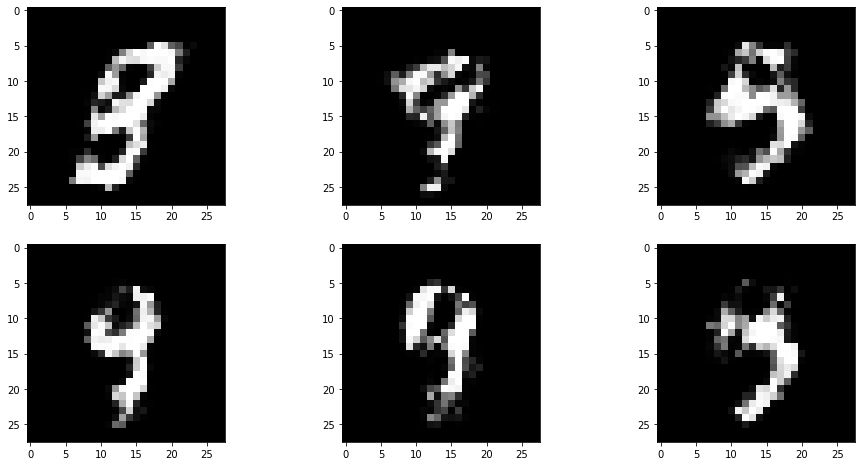

In [25]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass

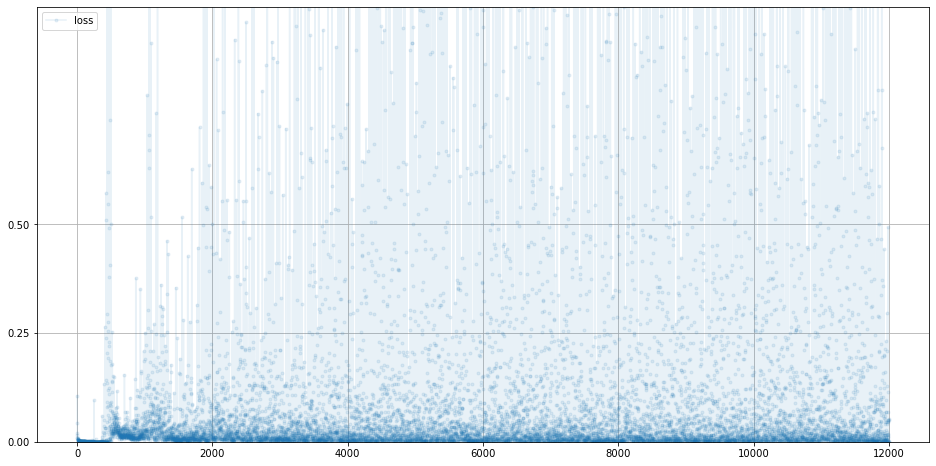

In [23]:
D.plot_progress()

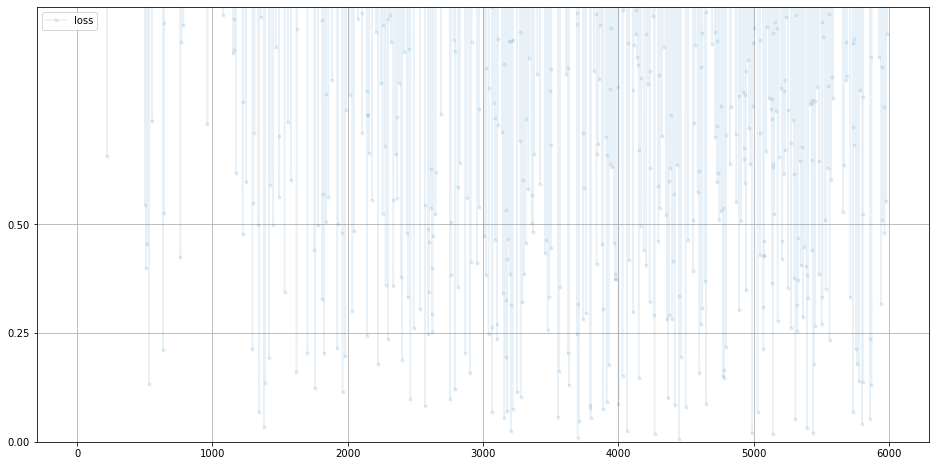

In [24]:
# 생성기가 판별기의 성능에 뒤쳐지는 경우 손실이 튄다. 
# BCE loss의 경우에 균형점에 도달하기 위해서는 0.69(ln2) 정도로 수렴 해야한다고 함.
G.plot_progress()

In [26]:
%%time

# train Discriminator and Generator
epochs = 5

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:

        # train discriminator on true : 실제 데이터 - 1.0              
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
        # train discriminator on false : 가짜 데이터 - 0.0
        # use detach() so gradients in G are not calculated : G의 기울기가 계산되지 않게 detach 사용
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
        # train generator 
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
    
    
        pass
        

epoch =  1
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  2
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  3
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  4
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
counter =  540000
counter =  550000
counter =  560000
counter =  570000
counter =  580000
counter =  590000
counter =  600000
epoch =  5
counter =  610000
counter =  620000
counter =  630000
counter =  640000
counter =

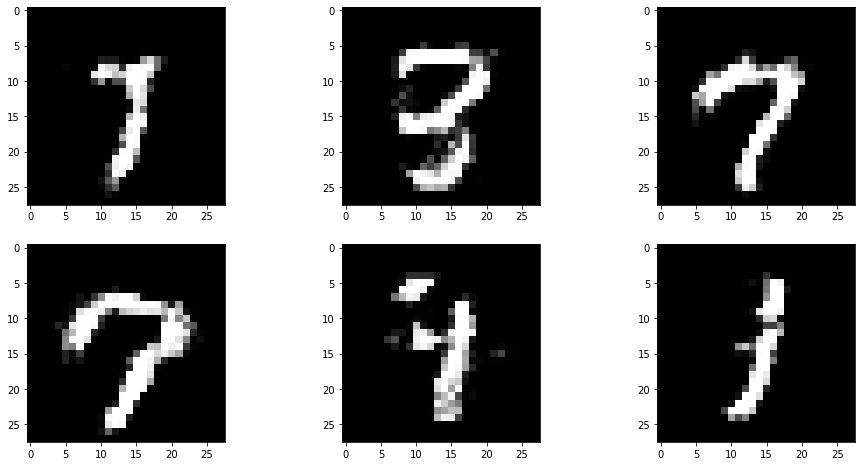

In [27]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass

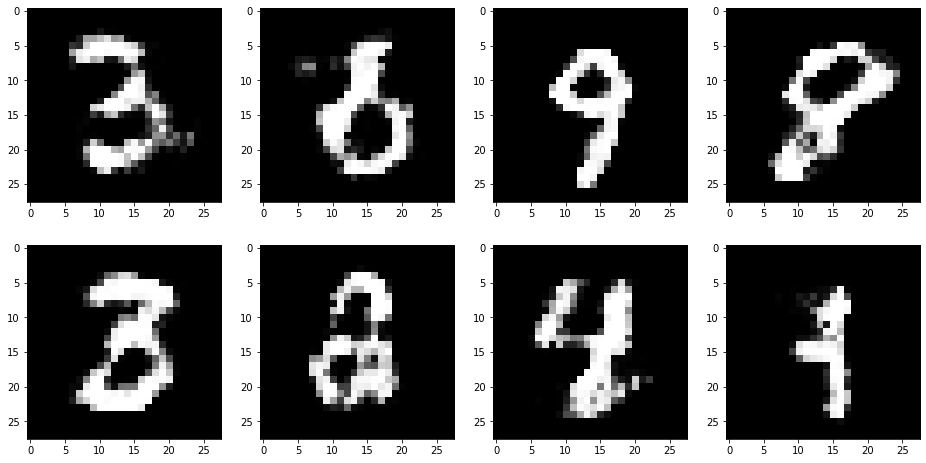

In [30]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,4, figsize=(16,8))
for i in range(2):
    for j in range(4):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='gray')
        pass
    pass